In [140]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd
import re
import implicit
import matplotlib.pyplot as plt
import random
import scipy.sparse as sparse

import sys
np.set_printoptions(threshold=sys.maxsize)

from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

In [141]:
utility_to_song, utility_to_artist, df = from_mongo_collection_to_utility_matrix(db.main_redo)

Madlib is the producer with the most samples, with 1559 sampled.
James Brown is the most sampled artist, sampled 641 times.


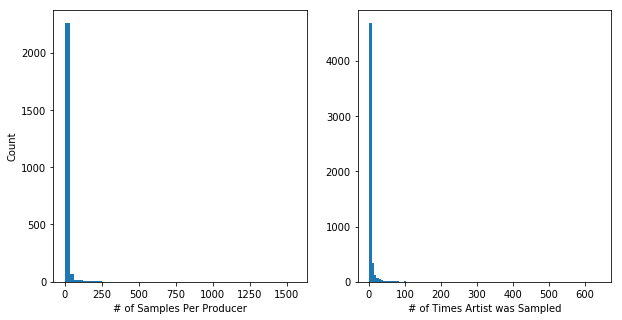

In [129]:
producers = utility_to_artist.sum(axis =0)
sampled_artists = utility_to_artist.sum(axis =1)

prod_with_most_samples = utility_to_artist.sum(axis = 0).idxmax()
most_sampled_artist = utility_to_artist.sum(axis = 1).idxmax()
most_samples = utility_to_artist.sum(axis = 0).max()
times_sampled = utility_to_artist.sum(axis = 1).max()

print(
"{} is the producer with the most samples, with {} sampled.\n\
{} is the most sampled artist, sampled {} times.".format(
        prod_with_most_samples, most_samples, most_sampled_artist, times_sampled))

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].set(xlabel = "# of Samples Per Producer", ylabel = "Count")
_ = ax[0].hist(producers, bins = 50)

# ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
ax[1].set(xlabel = "# of Times Artist was Sampled")
_ = ax[1].hist(sampled_artists, bins = 100)

In [103]:
utility_to_artist.sum(axis = 0).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

,Count
new_song_producer,
Madlib,1559
9th Wonder,1122
The Alchemist,940
DJ Paul,930
DJ Premier,861
Juicy J,815
Kanye West,640
Knxwledge.,588
Prince Paul,542


In [104]:
utility_to_artist.sum(axis = 1).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

#These results are shocking- Three 6 Mafia?

#I checked and they are right- three 6 gets sampled a lot.

,Count
sampled_artist,
James Brown,641
Three 6 Mafia,251
The Notorious B.I.G.,233
Public Enemy,229
Jay-Z,212
Kool & the Gang,196
Isaac Hayes,184
Michael Jackson,148
Eric B. & Rakim,142


In [143]:
# How sparse is matrix?
 
matrix_size = utility_to_artist.shape[0]*utility_to_artist.shape[1] # Number of possible interactions in the matrix
nonzeros = sum(utility_to_artist.sum(axis=0))
sparsity = 100*(1 - (nonzeros/matrix_size))
print([nonzeros, matrix_size, sparsity])

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

[29543, 13469505, 99.78066751525019]



There are 15809 unique records. There are 1324 producers. There are 7789 songs sampled.

In [144]:
from src.first_recommender_using_implict import get_model_and_user_items_from_utility_matrix
model, user_items_sparse = get_model_and_user_items_from_utility_matrix(utility_to_artist)

100%|██████████| 100.0/100 [00:06<00:00, 16.60it/s, loss=0.000813]


In [145]:
#What's up with Kanye?
print(utility_to_artist.loc["James Brown","Kanye West"])

#Actually, there is a 3 for Otis Redding- 
#is that because Kanye sampled him three times?

#An 11 for James Brown! Wow.

sum(utility_to_song.loc[:,"Kanye West"])
#Apparently he sampled 640 artists, also 640 songs.

11


649

In [9]:
model.recommend(1000, user_items)

[(1328, 0.038173527),
 (2577, 0.03122052),
 (5320, 0.030238453),
 (3846, 0.028904708),
 (3464, 0.027546264),
 (4200, 0.02601924),
 (3479, 0.022954363),
 (568, 0.022596516),
 (2036, 0.022526186),
 (1767, 0.019638106)]

In [10]:
model.similar_items(itemid = 2009)

[(1338, 0.08010418),
 (5, 0.08010418),
 (764, 0.08010418),
 (2916, 0.08010418),
 (2933, 0.08010418),
 (736, 0.08010418),
 (2469, 0.08010418),
 (2446, 0.08010418),
 (2342, 0.08010418),
 (1062, 0.08010418)]

In [125]:
# Make train set.
# First, we do in the most basic way: Set twenty percent of actual 
#interactions to non-interactions. Don't do it by row, just entire dataframe.
utility_to_artist_sparse = sparse.csr_matrix(utility_to_artist.T)

from src.make_train_set import make_train

train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse)

In [149]:
#Settings from https://jessesw.com/Rec-System/
# He says these are best
#However the method is deprecated- I can use the recommendations thing instead but no alpha
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

This method is deprecated. Please use the AlternatingLeastSquares class instead
100%|██████████| 50.0/50 [00:00<00:00, 55.88it/s]


In [146]:
from sklearn import metrics

def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [127]:
recomenders_for_4th_Disciple = recommend.pred_one_user(11)

In [137]:
ind = np.argwhere(recomenders_for_4th_Disciple)
data.columns[ind]

Index(['It's a New Day', 'Change the Beat (Female Version)', 'Rubber Jam',
       'Makin' Believe That It's You', 'In the Rain', 'Midnight Theme',
       'The Epic of Bitter Triumph', 'N.T.',
       'Love Theme From "Romeo and Juliet" (A Time for Us)', 'Do It Again',
       ...
       'Think Big', 'The Eye of a Needle', 'One Less Bell to Answer',
       'Don't Say Goodnight (It's Time for Love) (Parts 1 & 2)',
       'The Tragedy (Don't Do It)', 'Ain't No Half Steppin'',
       'Kool It (Here Comes the Fuzz)', 'Trilogy of Terror', 'L Dopa',
       'Do It Your Way'],
      dtype='object', length=1011)